In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/ali/tum/motion_planning/social_ai_practical_course'

In [2]:
# Imports
import numpy as np
from src.utils.evaluate_and_save import evaluate_and_save
from src.utils.linear_regressor import perform_linear_regression
from src.utils.column_import import columns



/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


# Linear regression

In [3]:
# Extracting individual columns from the dataset
s_x, s_y, v_x, v_y, a_x, a_y = columns
# Target vector y
y = np.concatenate([a_x[0:-2], a_y[0:-2]])    # a(k)
y.shape


(410546,)

In [4]:

# Input features X_first_model of the first model
A = - a_x[1:-1]                
B = - a_y[1:-1]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        
X_first_model = np.vstack((
    np.column_stack((A, C)),
    np.column_stack((B, D))
))
X_first_model.shape


(410546, 2)

Mean Squared Error (MSE): 3.5429e-03
Mean Absolute Error (MAE): 1.1927e-02
R-squared (R²) Score: 9.8918e-01


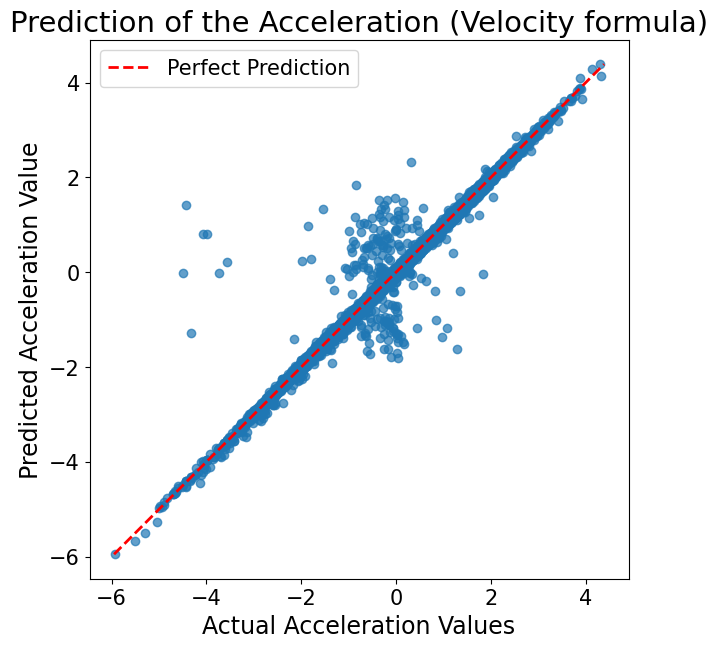

In [5]:
# First model
first_model = perform_linear_regression(X_first_model, y, 'Prediction of the Acceleration (Velocity formula)')

In [6]:
# Input features X_second_model of the second model
dt = 0.04
A = - a_x[1:-1]                                 
B = - a_y[1:-1]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        
X_second_model = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
))
X_second_model.shape


(410546, 2)

Mean Squared Error (MSE): 3.5429e-03
Mean Absolute Error (MAE): 1.1927e-02
R-squared (R²) Score: 9.8918e-01


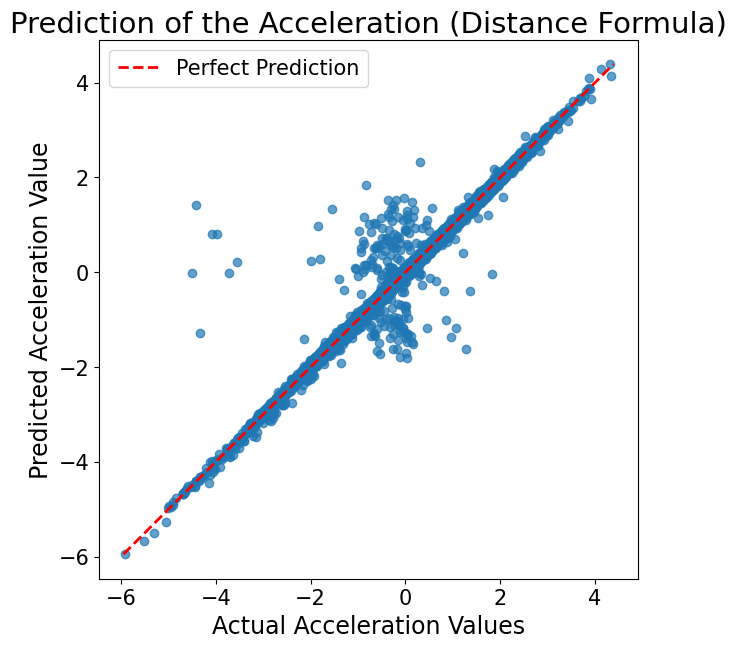

In [7]:
# Second model
second_model = perform_linear_regression(X_second_model, y, 'Prediction of the Acceleration (Distance Formula)')


## Comparison of the acceleration results of the first and second model

Mean Squared Error (MSE): 1.3437e-09
Mean Absolute Error (MAE): 1.4509e-06
R-squared (R²) Score: 1.0000e+00


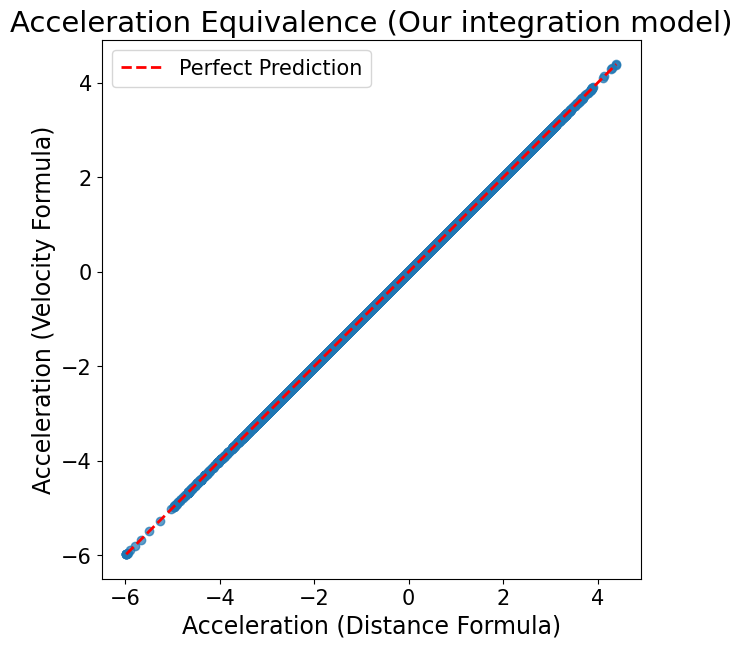

In [8]:

y_pred_first_model =  first_model.predict(X_first_model)
y_pred_second_model =  second_model.predict(X_second_model)
evaluate_and_save(y_pred_first_model, y_pred_second_model, 'Acceleration Equivalence (Our integration model)', 'Acceleration (Distance Formula)', 'Acceleration (Velocity Formula)')


# Run the integration (Baackwards step)

Mean Squared Error (MSE): 5.4042e+01
Mean Absolute Error (MAE): 7.3513e+00
R-squared (R²) Score: -4.1562e-02


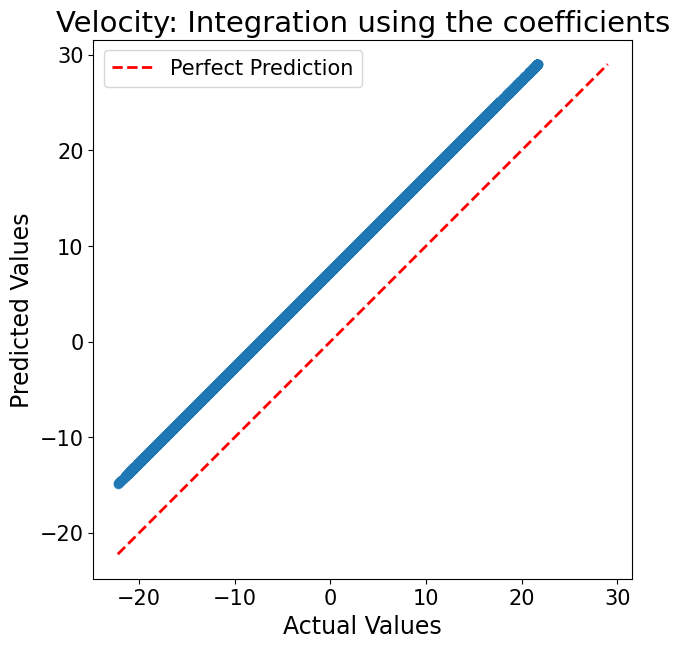

Mean Squared Error (MSE): 5.4042e+01
Mean Absolute Error (MAE): 7.3513e+00
R-squared (R²) Score: -2.3076e+00


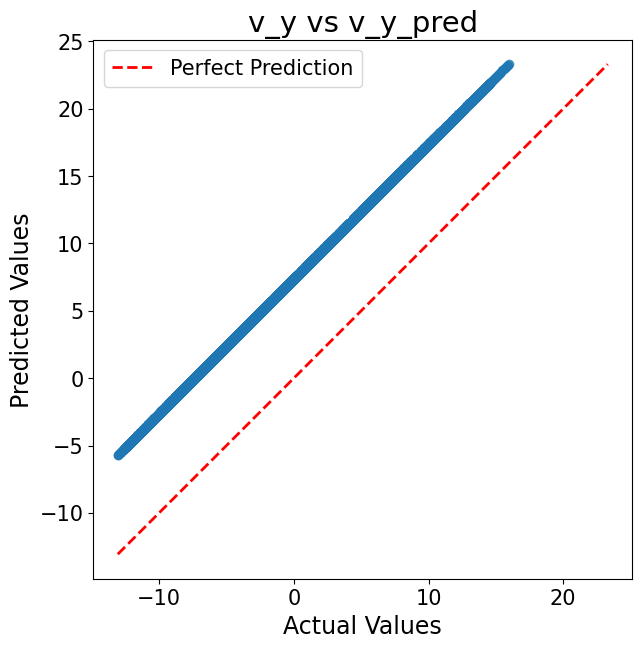

Mean Squared Error (MSE): 2.4129e+05
Mean Absolute Error (MAE): 4.9122e+02
R-squared (R²) Score: -2.1904e+02


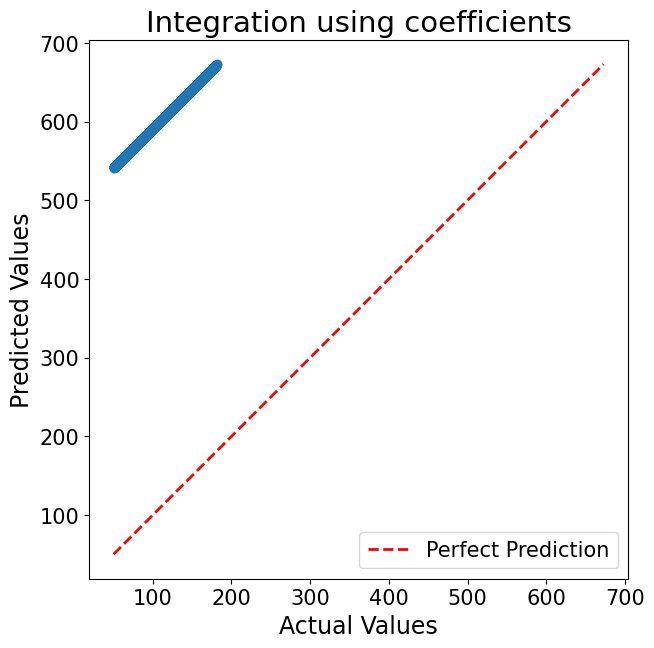

Mean Squared Error (MSE): 2.4129e+05
Mean Absolute Error (MAE): 4.9122e+02
R-squared (R²) Score: -5.5475e+02


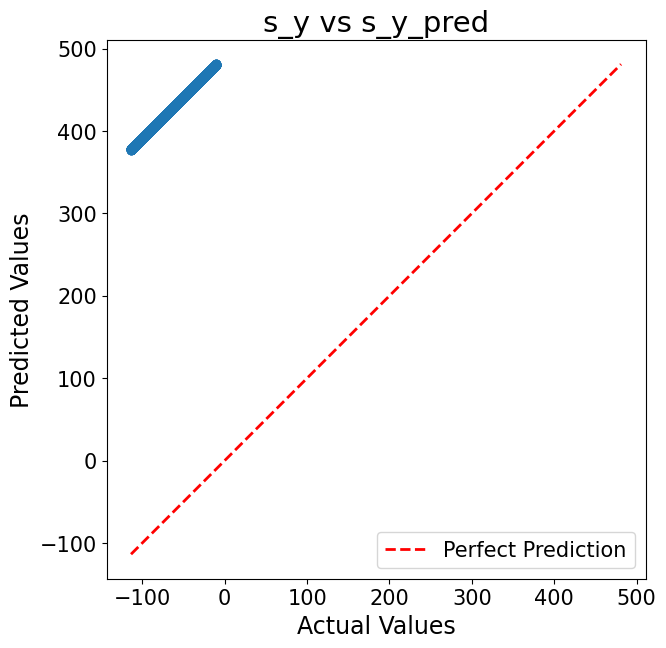

In [9]:

# Extracting coefficients from the models
c_1_overline = first_model.coef_[0]
c_2_overline = first_model.coef_[1]
c_3_overline = second_model.coef_[0]
c_4_overline = second_model.coef_[1]
# Calculating inverse coefficients for later use
c_2 = 1 / c_2_overline
c_1 = c_1_overline * c_2
c_4 = 1 / c_4_overline
c_3 = c_3_overline * c_4
# Extracting different time steps and variables
s_x_0 = s_x[:-2]
s_y_0 = s_y[:-2]
s_x_1 = s_x[1:-1]
s_y_1 = s_y[1:-1]
s_x_2 = s_x[2:]
s_y_2 = s_y[2:]
v_x_1 = v_x[1:-1]
v_y_1 = v_y[1:-1]
v_x_2 = v_x[2:]
v_y_2 = v_y[2:]
a_x_1 = a_x[1:-1]
a_y_1 = a_y[1:-1]
a_x_0 = a_x[:-2]
a_y_0 = a_y[:-2]
# Prediction using the first model
a_xy_0_pred_first_model = first_model.predict(X_first_model)
# Splitting the predictions for x and y components
half = int(len(a_xy_0_pred_first_model) / 2)
a_x_0_pred = a_xy_0_pred_first_model[:half]
a_y_0_pred = a_xy_0_pred_first_model[half:]
# Predicting velocity for the next time step
t = 0
v_x_2_pred = c_2 * a_x_0_pred + c_1 * a_x_1 + v_x_1 - t
v_y_2_pred = c_2 * a_y_0_pred + c_1 * a_y_1 + v_y_1 - t
# Evaluating the predictions
evaluate_and_save(v_x_2, v_x_2_pred, 'Velocity: Integration using the coefficients')
evaluate_and_save(v_y_2, v_y_2_pred, 'v_y vs v_y_pred')
# Prediction using the second model
a_xy_0_pred_second_model = second_model.predict(X_second_model)
# Splitting the predictions for x and y components
half = int(len(a_xy_0_pred_second_model) / 2)
a_x_0_pred = a_xy_0_pred_second_model[:half]
a_y_0_pred = a_xy_0_pred_second_model[half:]
t = 200
#t = 0
# Predicting position for the next time step
s_x_2_pred = s_x_1 + dt * v_x_1 + c_3 * a_x_1 + c_4 * a_x_0_pred - t
s_y_2_pred = s_y_1 + dt * v_y_1 + c_3 * a_y_1 + c_4 * a_y_0_pred - t
# Evaluating the predictions
evaluate_and_save(s_x_2, s_x_2_pred, 'Integration using coefficients')
evaluate_and_save(s_y_2, s_y_2_pred, 's_y vs s_y_pred')
# Creating a dictionary of the predicted columns
predicted_columns = {
    's_x': s_x_2_pred,
    's_y': s_y_2_pred,
    'v_x': v_x_2_pred,
    'v_y': v_y_2_pred,
    'a_x': a_x_0_pred,
    'a_y': a_y_0_pred
}
